# Looking for Needed Balance Changes

### Purpose
This notebook was created to find OP and UP brawlers based on betweenness centrality.

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import powerlaw
from scipy.stats import skew

## Downloading Data

### Brawler Nodes

In [2]:
df_brawlers = pd.read_csv("../outputs/graph-data/brawlers.csv")
df_brawlers.head()

,Id,Label
0,SHELLY,SHELLY
1,COLT,COLT
2,BULL,BULL
3,BROCK,BROCK
4,RICO,RICO


## Utility Functions

### Computing Weighted Betweenness Centrality

In [3]:
def weighted_betweenness_centrality(G: nx.Graph) -> pd.DataFrame:
    """
    Computes the weighted betweenness centrality of nodes in a graph.

    Args:
        G (nx.Graph): A NetworkX graph with edge weights.

    Returns:
        pd.DataFrame: A DataFrame with two columns:
                      - 'brawler': Node ID
                      - 'Weighted Betweenness Centrality': Centrality value
    """
    centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)
    
    df = pd.DataFrame({
        'brawler': list(centrality.keys()),
        'Weighted Betweenness Centrality': list(centrality.values())
    })

    return df


### Attacking Node

In [4]:
def attack(G: nx.Graph, id_of_node_to_attack: str) -> nx.Graph:
    """
    Get the graph after a node is attacked.

    Args:
        G (nx.Graph): NetworkX graph.
        id_of_node_to_attack (str): ID of node to attack.
    Returns
        G_attacked (nx.Graph): Graph without attacked node.
    """
    G_attacked = G.copy()
    G_attacked.remove_node(id_of_node_to_attack)
    return G_attacked

### Getting Change in Mean Weighted Betweenness Centrality when Attacked

In [5]:
def delta_mean_betweenness_centrality(
    G: nx.graph, id_of_node_to_attack: str
) -> float:
    """
    Get the change in mean betweenness centrality of a graph after 
    attacking a node.

    Args:
        G (nx.Graph): NetworkX graph.
        id_of_node_to_attack (str): ID of node to attack.
    Returns
        change (float): Change in betweenness centrality.
    """
    # Get initial mean betweenness centrality (mbc)
    bc_initial = weighted_betweenness_centrality(G)
    mbc_initial = bc_initial["Weighted Betweenness Centrality"].mean()

    # Get mean betweenness centrality after attack
    G_after_attack = attack(G, id_of_node_to_attack)
    bc_after_attack = weighted_betweenness_centrality(G_after_attack)
    mbc_after_attack = bc_after_attack[
        "Weighted Betweenness Centrality"
    ].mean()

    # Get change in betweenness centrality
    change = mbc_after_attack - mbc_initial
    return change

### Getting Outliers

In [6]:
def extract_outliers(df: pd.DataFrame, col_name: str):
    """
    Get the outliers in a pandas DataFrame based on a column.

    Args:
        df (pd.DataFrame): Pandas DataFrame that contains the data.
        col_name (str): Name of the column that will determine outliers.
    Returns:
        df_outliers (pd.DataFrame): Pandas DataFrame with outliers.
    """
    # Describe the dataframe
    df_describe = df.describe()

    # Compute iqr
    iqr = df_describe[col_name]["75%"] - df_describe[col_name]["25%"]

    # Get range of inliers
    max_inlier_val = df_describe[col_name]["75%"] + (1.5 * iqr)
    min_inlier_val = df_describe[col_name]["25%"] - (1.5 * iqr)

    # Get outliers
    df_outliers = df[
        (df[col_name] < min_inlier_val) |
        (df[col_name] > max_inlier_val)
    ]
    return df_outliers

## Creating Graphs

### Victory Graph

#### Getting Victory Graph Edges

In [7]:
df_win_edges = pd.read_csv(
    "../outputs/graph-data/edges/winning-edges-beginners.csv"
)

#### Creating NetworkX Graph

In [8]:
G_win = nx.Graph() # Initialize graph

# Adding brawler nodes
for brawler in df_brawlers["Id"]:
    G_win.add_node(brawler)

# Add weighted edges to the victory graph
for index, row in df_win_edges.iterrows():
    G_win.add_edge(row['Source'], row['Target'], weight=row['Weight'])

#### Getting Weighted Betweenness Centrality of Brawlers

In [9]:
# Create a dataframe for analyzing brawlers
df_wins = weighted_betweenness_centrality(G_win)

# Preview df_wins
df_wins.head()

,brawler,Weighted Betweenness Centrality
0,SHELLY,0.000000
1,COLT,0.000000
2,BULL,0.000234
3,BROCK,0.000701
4,RICO,0.011454


#### Getting Change in Mean Weighted Betweenness Centrality when Attacked

In [10]:
df_wins["Change in Weighted Betweenness Centrality"] = (
    df_wins["brawler"].apply(
        lambda brawler: delta_mean_betweenness_centrality(G_win, brawler)
    )
)

df_wins.head()

,brawler,Weighted Betweenness Centrality,Change in Weighted Betweenness Centrality
0,SHELLY,0.000000,-0.000045
1,COLT,0.000000,-0.000125
2,BULL,0.000234,0.000152
3,BROCK,0.000701,0.000101
4,RICO,0.011454,0.000335


In [11]:
df_wins.to_csv("../outputs/graph-data/winner-brawler-nodes.csv", index = False)

### Defeat Graph

#### Getting Defeat Graph Edges

In [12]:
df_lose_edges = pd.read_csv(
    "../outputs/graph-data/edges/losing-edges-beginners.csv"
)
df_lose_edges.head()

,Source,Target,Type,Weight,probability
0,8-BIT,BEA,Undirected,1.521749,0.657143
1,8-BIT,BYRON,Undirected,1.388899,0.720000
2,8-BIT,MAX,Undirected,1.384625,0.722222
3,8-BIT,ROSA,Undirected,1.384625,0.722222
4,8-BIT,RUFFS,Undirected,1.000010,1.000000


#### Creating NetworkX Graph

In [13]:
G_lose = nx.Graph() # Initialize graph

# Adding brawler nodes
for brawler in df_brawlers["Id"]:
    G_lose.add_node(brawler)

# Add weighted edges to the victory graph
for index, row in df_lose_edges.iterrows():
    G_lose.add_edge(row['Source'], row['Target'], weight=row['Weight'])

#### Getting Weighted Betweenness Centrality of Brawlers

In [14]:
# Create a dataframe for analyzing brawlers
df_losses = weighted_betweenness_centrality(G_lose)

# Preview df_lose
df_losses.head()

,brawler,Weighted Betweenness Centrality
0,SHELLY,0.092567
1,COLT,0.031791
2,BULL,0.034128
3,BROCK,0.010986
4,RICO,0.006545


#### Getting Change in Mean Weighted Betweenness Centrality when Attacked

In [15]:
df_losses["Change in Weighted Betweenness Centrality"] = (
    df_losses["brawler"].apply(
        lambda brawler: delta_mean_betweenness_centrality(G_lose, brawler)
    )
)

df_losses.head()

,brawler,Weighted Betweenness Centrality,Change in Weighted Betweenness Centrality
0,SHELLY,0.092567,-0.000739
1,COLT,0.031791,0.000489
2,BULL,0.034128,-0.000266
3,BROCK,0.010986,0.000273
4,RICO,0.006545,0.000171


In [16]:
df_losses.to_csv("../outputs/graph-data/loser-brawler-nodes.csv", index = False)

## Analyzing Graphs

### Victory Graph

#### Distribution of Weighted Betweenness Centrality

In [17]:
# Fit the data to a power law and an exponential distribution.
win_powerlaw_fit = powerlaw.Fit(df_wins["Weighted Betweenness Centrality"])

# Perform the likelihood ratio test.
## This test compares the goodness of fit of the power law and 
## exponential models.
R_win, p_win = win_powerlaw_fit.distribution_compare(
    'power_law', 'exponential'
)

print(f"R-value (Power Law vs. Exponential): {R_win:.4f}")
print(f"P-value (Power Law vs. Exponential): {p_win:.4f}")

# The R-value tells us which model is a better fit:
# R > 0: Power law is a better fit.
# R < 0: Exponential is a better fit.
# The p-value tells us if that difference is statistically significant.
if R_win > 0 and p_win < 0.05:
    print(
        "\nConclusion: The data is a significantly better fit for a power-law"
        " distribution."
    )
elif R_win < 0 and p_win < 0.05:
    print(
        "\nConclusion: The data is a significantly better fit for an "
        "exponential distribution."
    )
else:
    print(
        "\nConclusion: There is no statistically significant difference "
        "between the two models."
    )
    print("Further analysis or a different model may be needed.")


Calculating best minimal value for power law fit
R-value (Power Law vs. Exponential): 3.1828
P-value (Power Law vs. Exponential): 0.1255

Conclusion: There is no statistically significant difference between the two models.
Further analysis or a different model may be needed.


Values less than or equal to 0 in data. Throwing out 0 or negative values


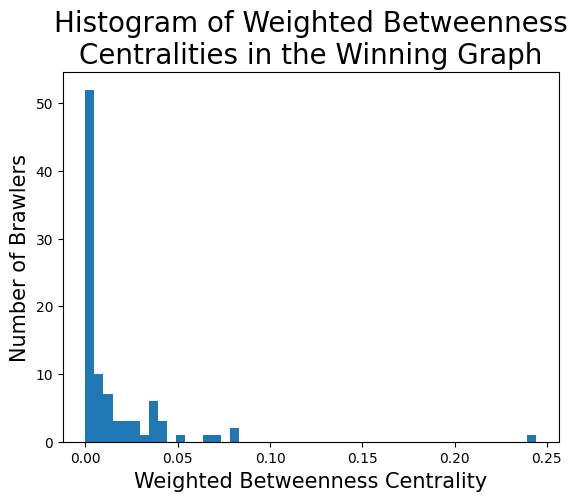

In [18]:
plt.hist(
    df_wins["Weighted Betweenness Centrality"], 
    bins = 50
)
plt.title(
    "Histogram of Weighted Betweenness\nCentralities in the Winning Graph", 
    fontsize = 20
)
plt.ylabel("Number of Brawlers", fontsize = 15)
plt.xlabel("Weighted Betweenness Centrality", fontsize = 15)
plt.show()

#### Average Clustering Coefficients of Nodes

In [19]:
print(
    "Average Clustering Coefficient:", 
    nx.average_clustering(G_win)
)

Average Clustering Coefficient: 0.13643800227029262


#### OP Brawlers

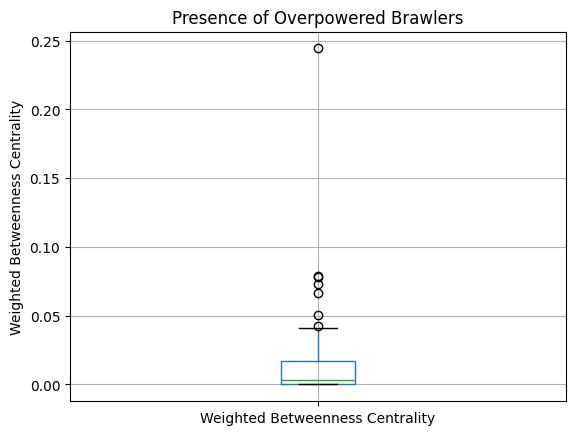

In [20]:
df_wins.boxplot(column="Weighted Betweenness Centrality")
plt.title("Presence of Overpowered Brawlers")
plt.ylabel("Weighted Betweenness Centrality")
plt.show()

In [21]:
(
    extract_outliers(df_wins, "Weighted Betweenness Centrality")
        .sort_values(
            "Weighted Betweenness Centrality", 
            ascending = False
        )
)# ["brawler"].values

,brawler,Weighted Betweenness Centrality,Change in Weighted Betweenness Centrality
69,DOUG,0.244273,0.002220
72,CHARLIE,0.079009,0.000371
74,KIT,0.078308,-0.000783
90,JAE-YONG,0.072698,0.000648
91,KAZE,0.066854,0.000160
68,CORDELIUS,0.050608,0.000492
83,KENJI,0.042543,0.000458


### Defeat Graph

#### Distribution of Weighted Betweenness Centrality

In [22]:
# Fit the data to a power law and an exponential distribution.
lose_powerlaw_fit = powerlaw.Fit(df_losses["Weighted Betweenness Centrality"])

# Perform the likelihood ratio test.
## This test compares the goodness of fit of the power law and 
## exponential models.
R_lose, p_lose = lose_powerlaw_fit.distribution_compare(
    'power_law', 'exponential'
)

print(f"R-value (Power Law vs. Exponential): {R_lose:.4f}")
print(f"P-value (Power Law vs. Exponential): {p_lose:.4f}")

# The R-value tells us which model is a better fit:
# R > 0: Power law is a better fit.
# R < 0: Exponential is a better fit.
# The p-value tells us if that difference is statistically significant.
if R_lose > 0 and p_lose < 0.05:
    print(
        "\nConclusion: The data is a significantly better fit for a power-law"
        " distribution."
    )
elif R_lose < 0 and p_lose < 0.05:
    print(
        "\nConclusion: The data is a significantly better fit for an "
        "exponential distribution."
    )
else:
    print(
        "\nConclusion: There is no statistically significant difference "
        "between the two models."
    )
    print("Further analysis or a different model may be needed.")


Calculating best minimal value for power law fit
R-value (Power Law vs. Exponential): 0.0540
P-value (Power Law vs. Exponential): 0.9696

Conclusion: There is no statistically significant difference between the two models.
Further analysis or a different model may be needed.


Values less than or equal to 0 in data. Throwing out 0 or negative values


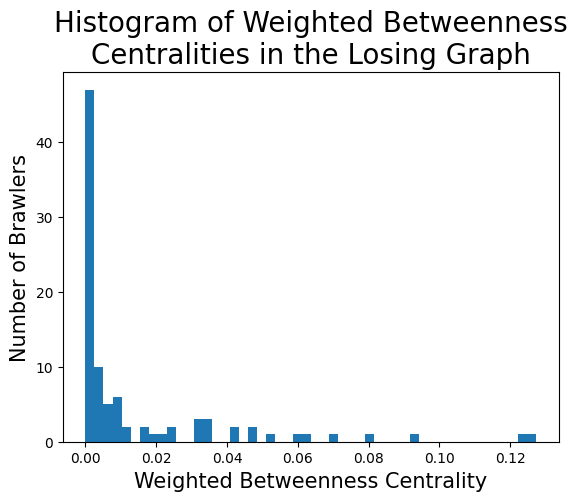

In [23]:
plt.hist(
    df_losses["Weighted Betweenness Centrality"], 
    bins = 50
)
plt.title(
    "Histogram of Weighted Betweenness\nCentralities in the Losing Graph", 
    fontsize = 20
)
plt.ylabel("Number of Brawlers", fontsize = 15)
plt.xlabel("Weighted Betweenness Centrality", fontsize = 15)
plt.show()

#### Average Clustering Coefficients of Nodes

In [24]:
print(
    "Average Clustering Coefficient:", 
    nx.average_clustering(G_lose)
)

Average Clustering Coefficient: 0.1813298416519548


#### UP Brawlers

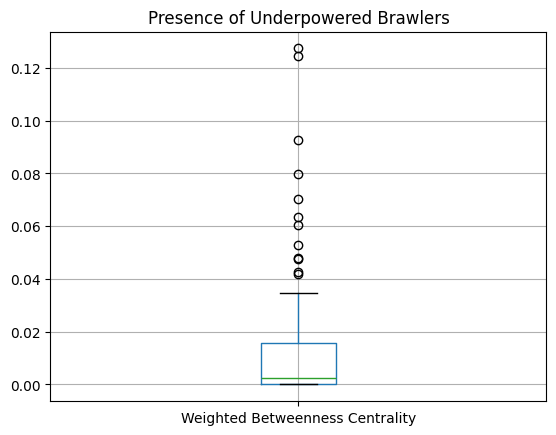

In [25]:
df_losses.boxplot(column="Weighted Betweenness Centrality")
plt.title("Presence of Underpowered Brawlers")
plt.show()

In [26]:
(
    extract_outliers(df_losses, "Weighted Betweenness Centrality")
        .sort_values(
            "Weighted Betweenness Centrality", 
            ascending = False
        )
)

,brawler,Weighted Betweenness Centrality,Change in Weighted Betweenness Centrality
44,STU,0.127396,0.001198
16,PAM,0.124591,0.000672
0,SHELLY,0.092567,-0.000739
6,BARLEY,0.079710,0.000517
21,GENE,0.070360,-0.000086
13,POCO,0.063347,0.000178
9,DYNAMIKE,0.060542,-0.000646
10,EL PRIMO,0.053062,0.000633
41,BYRON,0.047920,0.000286
8,NITA,0.047452,0.000415


### Combining Boxplots for Finding the Presence of OP and UP Brawlers

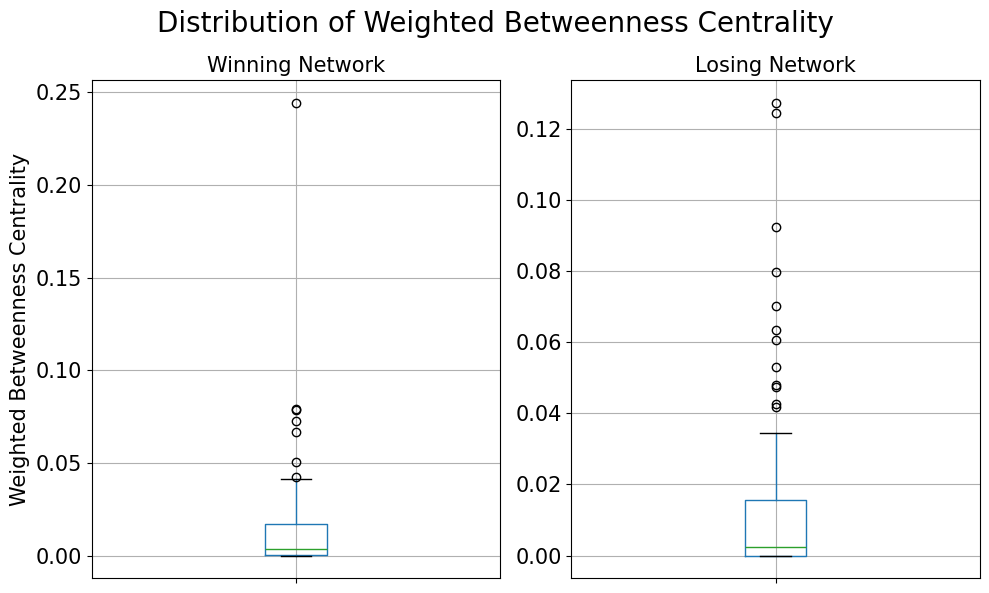

In [36]:
import matplotlib.pyplot as plt

# Create one single figure and two axes (subplots) that will hold our boxplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6)) # 1 row, 2 columns

# Create the first boxplot on the first axis (axs[0])
df_wins.boxplot(
    column="Weighted Betweenness Centrality", ax=axs[0], fontsize=15
)
axs[0].set_title("Winning Network", fontsize=15) # Changed title
axs[0].set_ylabel("Weighted Betweenness Centrality", fontsize=15)
axs[0].set_xticklabels(['']) # Remove the default 'Weighted Betweenness Centrality' x-label

# Create the second boxplot on the second axis (axs[1])
df_losses.boxplot(
    column="Weighted Betweenness Centrality", ax=axs[1], fontsize=15
)
axs[1].set_title("Losing Network", fontsize=15) # Changed title
axs[1].set_xticklabels(['']) # Remove the default 'Weighted Betweenness Centrality' x-label

# Set a common title for the entire figure
fig.suptitle('Distribution of Weighted Betweenness Centrality', fontsize=20) # Improved title

# Automatically adjust the layout to prevent overlapping elements
plt.tight_layout()

# Save the combined figure for your paper
# plt.savefig('figures/centrality_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

## Evaluating Impact of Attacks

### Victory Graph

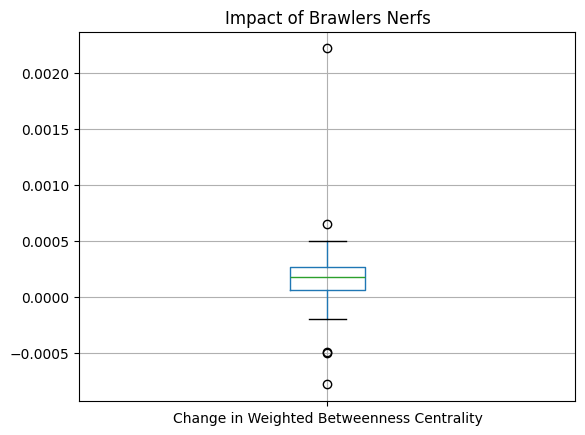

In [28]:
df_wins.boxplot(column="Change in Weighted Betweenness Centrality")
plt.title("Impact of Brawlers Nerfs")
plt.show()

In [29]:
(
    extract_outliers(df_wins, "Change in Weighted Betweenness Centrality")
        .sort_values(
            "Change in Weighted Betweenness Centrality", 
            ascending = False
        )
)

,brawler,Weighted Betweenness Centrality,Change in Weighted Betweenness Centrality
69,DOUG,0.244273,0.002220
90,JAE-YONG,0.072698,0.000648
70,PEARL,0.034362,-0.000492
78,DRACO,0.022440,-0.000503
74,KIT,0.078308,-0.000783


### Defeat Graph

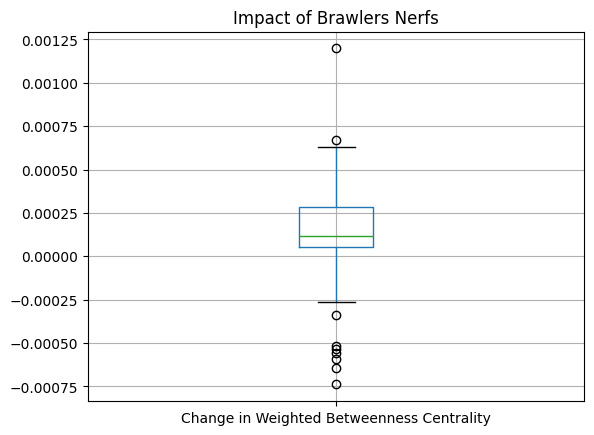

In [30]:
df_losses.boxplot(column="Change in Weighted Betweenness Centrality")
plt.title("Impact of Brawlers Nerfs")
plt.show()

In [31]:
(
    extract_outliers(df_losses, "Change in Weighted Betweenness Centrality")
        .sort_values(
            "Change in Weighted Betweenness Centrality", 
            ascending = False
        )
)

,brawler,Weighted Betweenness Centrality,Change in Weighted Betweenness Centrality
44,STU,0.127396,0.001198
16,PAM,0.124591,0.000672
22,TICK,0.033427,-0.000341
45,BELLE,0.031323,-0.000515
39,AMBER,0.023375,-0.000533
82,MOE,0.021038,-0.000556
61,CHESTER,0.018467,-0.000592
9,DYNAMIKE,0.060542,-0.000646
0,SHELLY,0.092567,-0.000739
